In [8]:
EXP_DIR = "/kaggle/output/exp_001"
!rm -rf {EXP_DIR}/vis

In [9]:
import os
import sys

PACKAGE_DIR = "/kaggle/src"
sys.path.append(PACKAGE_DIR)
sys.path.append(os.path.join(PACKAGE_DIR, "Penguin-ML-Library"))

In [10]:
import json
import math
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import yaml
from PIL import Image
from tqdm import tqdm


In [11]:
from const import TARGET_COLS

CFG = yaml.safe_load(open(os.path.join(PACKAGE_DIR, "config.yaml"), "r"))

In [12]:
# 変更しないでください
intrinsic_matrix = np.array([[226.16438356, 0.0, 63.62426614], [0.0, 224.82352941, 11.76], [0.0, 0.0, 1.0]])


def camera_to_image(P_camera, intrinsic_matrix):
    P_image_homogeneous = np.dot(intrinsic_matrix, P_camera)
    P_image = P_image_homogeneous[:2] / P_image_homogeneous[2]
    return P_image


def project_trajectory_to_image_coordinate_system(trajectory: np.ndarray, intrinsic_matrix: np.ndarray):
    """車両中心座標系で表現されたtrajectoryをカメラ座標系に投影する"""
    # カメラの設置されている高さ(1.22m)まで座標系をズラす
    trajectory_with_offset = trajectory.copy()
    trajectory_with_offset[:, 2] = trajectory_with_offset[:, 2] + 1.22

    # 座標の取り方を変更する
    road_to_camera = np.array([[0, 0, 1], [-1, 0, 0], [0, 1, 0]])
    trajectory_camera = trajectory_with_offset @ road_to_camera
    trajectory_image = np.array([camera_to_image(p, intrinsic_matrix) for p in trajectory_camera if p[2] > 0])
    if len(trajectory_image) == 0:
        return np.array([[0, 0]])
    return trajectory_image


def overlay_trajectory(
    gt_trajectory: np.ndarray,
    pred_trajectory: np.ndarray,
    velocity: float,
    acceleration: float,
    angle: float,
    image: Image.Image,
    intrinsic_matrix: np.ndarray,
    figsize=(5.12 * 2.2, 2.56),
    save_path=None,
    plot=True,
):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    ax_image, ax_trajectory = axs
    # ax_image.subplots_adjust(left=0, right=1, bottom=0, top=1)

    # 軌跡をカメラ座標に変換して画像上に描画
    ax_image.set_axis_off()
    ax_image.imshow(image)

    trajectory_image = project_trajectory_to_image_coordinate_system(gt_trajectory, intrinsic_matrix)
    ax_image.plot(
        trajectory_image[:, 0],
        trajectory_image[:, 1],
        marker="o",
        color="red",
        alpha=1.0,
        markersize=5,
        linestyle="solid",
    )
    trajectory_image = project_trajectory_to_image_coordinate_system(pred_trajectory, intrinsic_matrix)
    ax_image.plot(
        trajectory_image[:, 0],
        trajectory_image[:, 1],
        marker="o",
        color="yellow",
        alpha=1.0,
        markersize=5,
        linestyle="solid",
    )
    ax_image.set_xlim(0, 128)
    ax_image.set_ylim(64, 0)

    # 軌跡を車両中心座標系で描画
    # ax_trajectory.set_axis_off()
    ax_trajectory.set_aspect("equal")
    ax_trajectory.set_facecolor("gray")
    ax_trajectory.set_xlim(-20, 20)
    ax_trajectory.set_ylim(0, 40)

    ax_trajectory.plot(
        -gt_trajectory[:, 1],
        gt_trajectory[:, 0],
        marker="o",
        color="red",
        alpha=1.0,
        markersize=5,
    )
    ax_trajectory.plot(
        -pred_trajectory[:, 1],
        pred_trajectory[:, 0],
        marker="o",
        color="yellow",
        alpha=1.0,
        markersize=5,
    )
    rad = math.radians(angle + 90)
    pos = np.array([math.cos(rad), math.sin(rad)]) * 10
    base = np.array([0, 0])
    ax_trajectory.quiver(
        base[0],
        base[1],
        pos[0],
        pos[1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="blue",
        width=0.01,
    )

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
    if plot:
        plt.show()
    plt.close()

In [13]:
train = pl.read_csv(os.path.join(CFG["dataset"]["competition_dir"], "train_features.csv")).sort("ID")
oof = pl.read_csv(f"{EXP_DIR}/oof.csv").sort("ID")

  0%|          | 0/43371 [00:00<?, ?it/s]

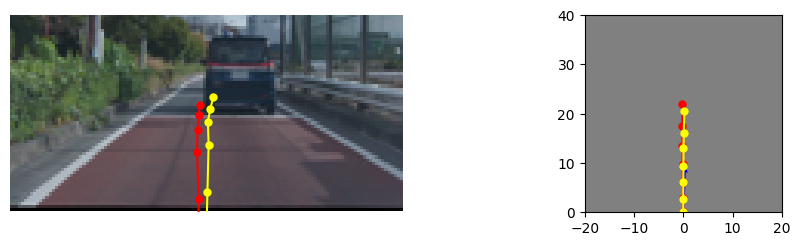

  0%|          | 1/43371 [00:00<2:19:27,  5.18it/s]

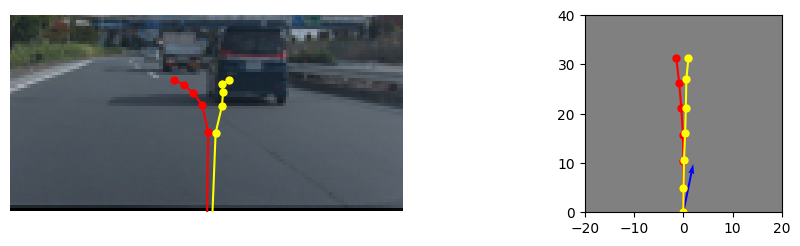

  0%|          | 2/43371 [00:00<1:47:12,  6.74it/s]

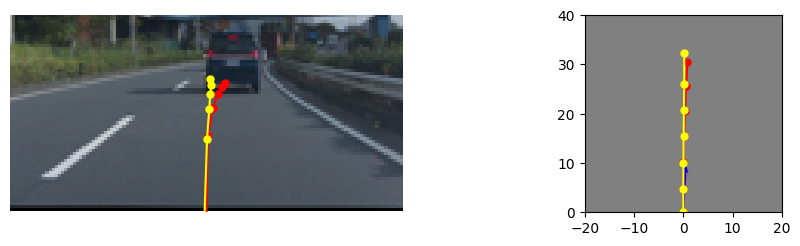

  2%|▏         | 1001/43371 [01:15<53:01, 13.32it/s] 


In [14]:
images_dir = Path("/kaggle/input/atmaCup#18_dataset/images/")

for i in tqdm(range(len(train))):
    sample_id = train["ID"][i]
    image = Image.open(images_dir / sample_id / "image_t.png")
    gt_trajectory = np.concatenate([[[0, 0, 0]], train[TARGET_COLS][i].to_numpy().reshape(-1, 3)], axis=0)
    pred_trajectory = np.concatenate(
        [[[0, 0, 0]], oof[["oof_" + c for c in TARGET_COLS]][i].to_numpy().reshape(-1, 3)], axis=0
    )

    overlay_trajectory(
        gt_trajectory,
        pred_trajectory,
        train["vEgo"][i],
        train["aEgo"][i],
        train["steeringAngleDeg"][i],
        image,
        intrinsic_matrix,
        save_path=f"{EXP_DIR}/vis/{sample_id}.png",
        plot=i < 3,
    )

    if i > 1000:
        break